# ML @ AMSI Bioinfosummer

# Welcome
Welcome to the workshop! This notebook explores what machine learning is and walks through some common pitfalls. 
In particular, we will aim to: 
 - Discuss what machine learning may or may not be
 - Conduct some simple exploratory analysis to understand our chosen dataset/question
 - Evaluate scenarios where model performance looks great but reduces significantly on unseen data
 - Provide a passing reference to several classes of model and metrics of model performance
 - Introduce key concepts of:
     - *overfitting*
     - *training/validation/testing*
     - *hyperparameters*
 
We will not try to teach the algorithms underlying any of the models but will provide some further resources at the bottom of this notebook. 

## Assumptions

*Prior knowledge:* 
The notebook assume familiarity with python, and a passing familiarity with the pandas, matplotlib/seaborn and numpy/scipy packages. A lot of comments have been placed around the code and the expectation is you should be able to follow along rather than write this code from scratch.  

*Setup:* 
You'll need to have access to this notebook and a python 3.9 instance with 
 - pandas
 - numpy
 - sklearn
 - matplotlib
 - scipy
 







# Task 1: Exploring the data and fitting a basic model

Here, we will explore a given dataset related to diabetes and fit a basic model using the scikit-learn package. We aims to 
 - understand the dataset, its variables and their relationship. 
 - introduce the pandas-profiling and scikit-learn packages. 
 - demonstrate how to fit a model using sklearn and look at the outputs. 


## Dataset

We will be making use of a dataset of 442 diabetes patients. This is relatively small in the machine leraning space but is common (or even large) for many clinical/bioinformatis analyses. 

10 attributes have been measured:
- age age in years
- sex
- bmi body mass index
- bp average blood pressure
- tc, total serum cholesterol
- ldl, low-density lipoproteins
- hdl, high-density lipoproteins
- tch, total cholesterol / HDL
- ltg, possibly log of serum triglycerides level
- glu, blood sugar level

The target to be predicted is "a quantitative measure of disease progression one year after baseline" (Efron et al. (2004)) though  its unclear exactly what this is.

The analysis goals from this dataset are typically of a predictive task in this area: 
>Two hopes were evident [from the data], that the model would produce accurate baseline predictions of response for future patients and that the form of the model would suggest which covariates were important factors in disease progression.

Further information is available at https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset and data is taken from the original paper https://tibshirani.su.domains/ftp/lars.pdf.

We will load in the relevant packages, adjust the dataset to be a binary prediction task, whereby a poor outcome is >100) and will make some adjustments to make the column nicer more descriptive.  

In [14]:
# Setup packages and load data
# Running this cell should show the top 10 
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport


def append_noise(df, n_noise=2):
    noise_measures = np.random.rand(df.shape[0],n_noise)
    noise_measures = StandardScaler().fit(noise_measures).transform(noise_measures)
    noise_names = ["noise_{}".format(i) for i in range(n_noise)]
    noise_df = pd.DataFrame(data=noise_measures,columns=noise_names)
    return(pd.concat([df,noise_df], axis=1))


def generate_diabetes_data(n_noise=2, n_corr=0):
    # Load in the data as a data.frame, split into X (features) and y (target) 
    X,y=datasets.load_diabetes(as_frame=True, return_X_y=True)

    # Target variable is a quantitative measure of disease progression one year after baseline
    # that we dichotimise (turn into two groups) to simplify some analysis. 
    y=1*(y>100)
    
    # We rename the variables to be more descriptive
    X.rename({'s1': 'tc', 
              's2': 'ldl', 
              's3': 'hdl',
              's4': 'tch',
              's5': 'ltg',
              's6': 'glu',}
             , axis=1, inplace=True)
    
    #if (n_corr>0):
    #    X=X.assign(glu2 = X['glu']+ np.random.randn(X.shape[0])/100)

    if n_noise>0:
        X=append_noise(X, n_noise)
        
    return (X, y)

from scipy.stats import multivariate_normal as mvn



def generate_novel_data(X_curr, n_samples=1000):
    n_noise=X_curr.filter(regex='noise').shape[1]
    #Reload data to drop noise and have continuous progression score
        # Load in the data as a data.frame, split into X (features) and y (target) 
    X,y=datasets.load_diabetes(as_frame=True, return_X_y=True)

    # We rename the variables to be more descriptive
    X.rename({'s1': 'tc', 
              's2': 'ldl', 
              's3': 'hdl',
              's4': 'tch',
              's5': 'ltg',
              's6': 'glu',}
             , axis=1, inplace=True)
             
    df=X.assign(y = y)

    sim_dat = mvn.rvs(mean = df.mean(), cov=df.cov(), size = n_samples)
    sim_X_y = pd.DataFrame(data = sim_dat, columns = df.columns)
    #sns.kdeplot(data=sim_X_y, x="y")


    sim_y=1*(sim_X_y['y']>100)
    sim_X=sim_X_y.drop(columns=['y'])
    
    if n_noise>0:
        sim_X=append_noise(sim_X, n_noise)
    
    return(sim_X, sim_y)
    

def plot_roc(y, yp, label="", ax=None):
    fpr, tpr, thresh = metrics.roc_curve(y, yp)
    auc = metrics.roc_auc_score(y, yp)
    if ax:
        ax.plot(fpr,tpr,label="{} AUC={:.2f}".format(label, auc))
    else:
        plt.plot(fpr,tpr,label="{} AUC={:.2f}".format(label, auc))


### 1. 1 Data exploration
We'll begin by exploring the data that is available. While we have a description of the fields, understanding the relationships between individual features and their relationship with the outcome of interest is informative for helping to understand downstream. 

Rather than try to generate a bunch of plots manually, we can make use of a package called *pandas-profiling*, which provides a bunch of handy plots. *This will take approximately 90 seconds to run*. After that a small report below will be generated that provides an overview of the different features and their relationships. 

**Examine the following:**

1. What are the different types of features - which are numerical? which are categorical? are any unclear?
2. Which features are correlated with each other? How strong are these?
3. Is there anything unexpected about the data?
4. Is there any missing data?
5. What does the target variable look like? What is its distribution? Are there any obvious relationships?



In [27]:
# This cell creates of the dataframe that has been entered. 
X, y = generate_diabetes_data(n_noise=200)

X_y = X.assign(y = y)
#print(X)

#profile = ProfileReport(X_y)

#profile.to_widgets()
# If you've installed pandas-profiling 3.1.0, you may need to replace the previous line, with the comment below. 
#profile.to_notebook_iframe()

X_sim, y_sim=generate_novel_data(X, n_samples=1000)
print(X_sim)


          age       sex       bmi        bp        tc       ldl       hdl  \
0    0.007678 -0.034938 -0.000992  0.033139 -0.011088 -0.007642  0.009725   
1    0.091446  0.045418  0.070535  0.120335  0.022138 -0.015394 -0.028603   
2    0.004750 -0.043908 -0.052948 -0.020575  0.056370  0.013795  0.076011   
3    0.021783  0.000015 -0.012655 -0.003803 -0.014964  0.001033  0.010923   
4    0.059281 -0.012984  0.103688  0.061998  0.005196  0.007476 -0.023043   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.020346 -0.011217  0.053852  0.023035 -0.025480  0.000602  0.007088   
996  0.015812  0.009673 -0.022207 -0.020098 -0.065624 -0.074632  0.067804   
997  0.018374 -0.047103  0.041612  0.044057 -0.011406 -0.016597  0.016517   
998 -0.020370 -0.097216  0.058473 -0.030115 -0.112569 -0.088203 -0.041719   
999  0.052963  0.009013  0.006388 -0.005569  0.033316  0.018412 -0.019102   

          tch       ltg       glu  ...  noise_190  noise_191  noise_192  \


### Fitting a model to the data

Lets fit a simple logistic regression to the data and look at how well it makes predictions on the data. The code below will fit a simple logistic regression , using only a single predictor (bmi), to allow for simple plots of the fit, and then using all available features. 

We begin by plotting the data, the model fit and some classic summary statistics. 

*Question*:
 - Which features are the most predictive?
 - How much improvement to you get if you combined features?
 - Try regenerating the dataset with some variables that are just noise (n_noise=<int>). What happens as you add more noisy variables?
 


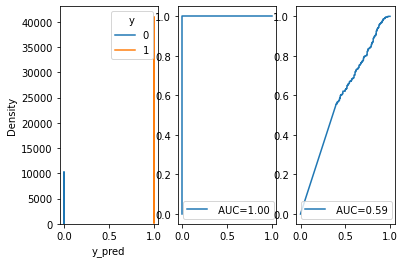

In [29]:
# If you feel like generating more data, uncomment this line. 
#X, y = generate_diabetes_data(n_noise=2, n_corr=1)

# The features used to construct the model
# Change these and see how the results change
#features="bmi"
#features="age"
#features=["bmi", "glu"]
features= X.columns

# sklearn models expect a 2D array. However, when only a single column is selected in pandas, it is a
# 1D array. This conditional checks for when our input is a single column and turns it into a 2D array for sklearn. 
# to 



if type(features)==str:
    X_train  = X.loc[:, features].values.reshape(-1,1)
    X_sim_eval   = X_sim.loc[:, features].values.reshape(-1,1)
else:
    X_train = X.loc[:, features]
    X_sim_eval = X_sim.loc[:, features]
        
#Construct a classifier
clf = LogisticRegression(penalty='none', solver="newton-cg").fit(X_train, y)

# Get preidcted labels from the classifier
y_pred = clf.predict_proba(X_train)[:,1]
y_sim_pred = clf.predict_proba(X_sim_eval)[:,1]


#
# Plot the results
fig, ax =plt.subplots(1,3)

# Plot the distribution of predicted values for people who progress and people who don't
# Could change to 'kind="hist"' if you want the histogram rather than density
sns.kdeplot(data=X_y.assign(y_pred = y_pred), x="y_pred", hue="y", ax=ax[0])

# PLot a ROC curve and show the area under the curve. 
plot_roc(y, y_pred, ax=ax[1])
ax[1].legend(loc=0)

# PLot a ROC curve and show the area under the curve. 
plot_roc(y_sim, y_sim_pred, ax=ax[2])
ax[2].legend(loc=0)

#print(clf.coef_, clf.intercept_)

<hr style="border:2px solid gray"> </hr>

# Exercise 2: How to overfit and how to detect

In the previous example, we built model on entire dataset and evaluated its performance on the same data. Here, we will explore some alternative frameworks for doing this and will evaluate how model performance changes. We'll also start to explore different models and how key parameters can be altered to change prediction performance. 

# Training and Test split

Questions: 
1. Run this a few times. Which values change? Why?
2. What is the best performance you can get by default? What is the worst performance you observe?
3. What happens to test performance as you add more noise variables?

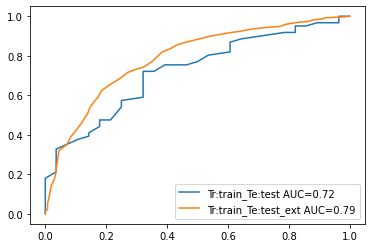

In [85]:
#Select a model to construct
#
#clf = sklearn.linear_model.LogisticRegression(penalty='l2',C=0.001)
#clf = sklearn.linear_model.LogisticRegression(penalty='none').fit(X, y)
clf = RandomForestClassifier(max_depth=20, random_state=0)



# If you feel like generating more data, uncomment this line. 
X, y = generate_diabetes_data(n_noise=200, n_corr=1)


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)




#pred_all=clf.predict_proba(X)[:,1]
#plt.figure(0).clf()

scenarios = {
                #"Tr:all_Te:all":    {"train":{'X':X,'y':y}, "test":{'X':X,'y':y}}, 
                #"Tr:train_Te:train":  {"train":{'X':X_train,'y':y_train}, "test":{'X':X_train,'y':y_train}}, 
                "Tr:train_Te:test":   {"train":{'X':X_train,'y':y_train}, "test":{'X':X_test,'y':y_test}}
            }

for name, sc in scenarios.items():
    clf.fit(sc['train']['X'], sc['train']['y'])
    yp=clf.predict_proba(sc['test']['X'])[:,1]
    yp2=clf.predict_proba(X_sim)[:,1]
    plot_roc(sc['test']['y'], yp, name)
    plot_roc(y_sim, yp2, name+"_ext")
    
plt.legend(loc=0)

Variability in the previous example motivates the use of cross validation
 - Add some box plots here
 - Compare different types of models
 - Look at impact of noise

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
scores = cross_val_score(clf, X, y, cv=10, scoring="roc_auc")
#sorted(sklearn.metrics.SCORERS.keys())
scores

# Overfitting via feature selection and model parameters
Its a big deal

In [ ]:
help('modules')

